# Rough ROMS analysis

In [25]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import xgcm
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram

In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 11.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41925,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 11.23 GiB
Comm: tcp://127.0.0.1:43499,Total threads: 1
Dashboard: /proxy/33807/status,Memory: 1.40 GiB
Nanny: tcp://127.0.0.1:39321,


In [3]:
# files:
base = '/g/data/e14/rmh561/ROMS/SAPEQ/OUT/';
#fgrd = xr.open_dataset(base + 'ocean_avg_ABLMe.nc').chunk({'ocean_time': 1})
favg = xr.open_dataset(base + 'ocean_avg_ABLMe.nc').chunk({'ocean_time': 1})
favg_mean = xr.open_dataset(base + 'ocean_avg_ABLMe.ncra.nc').chunk({'ocean_time': 1})
fhis = xr.open_dataset(base + 'ocean_his_ABLMe.nc').chunk({'ocean_time': 1})
fdia = xr.open_dataset(base + 'ocean_dia_ABLMe.nc').chunk({'ocean_time': 1})
fdia_mean = xr.open_dataset(base + 'ocean_dia_ABLMe.ncra.nc').chunk({'ocean_time': 1})

# Add z_rho/z_w as coordinate:
favg_mean.coords["z_rho"] = favg_mean.z_rho.fillna(0.)
favg_mean.coords["z_w"] = favg_mean.z_w.fillna(0.)
favg.coords["z_rho"] = favg.z_rho.fillna(0.)
favg.coords["z_w"] = favg.z_w.fillna(0.)
fdia.coords["z_rho"] = favg.z_rho.fillna(0.)
fdia.coords["z_w"] = favg.z_w.fillna(0.)

In [6]:
ln1,ln2 = -180.,-100.
lt1,lt2 = -6.,8.

ln1i,ln2i = int(abs(favg.lon_rho.isel(eta_rho=0)-ln1).argmin()),int(abs(favg.lon_rho.isel(eta_rho=0)-ln2).argmin())
lt1i,lt2i = int(abs(favg.lat_rho.isel(xi_rho=0)-lt1).argmin()),int(abs(favg.lat_rho.isel(xi_rho=0)-lt2).argmin())

t1,t2 = 100,200

# Limit time and space range for testing:
favg = favg.isel(xi_rho=slice(ln1i,ln2i)).isel(eta_rho=slice(lt1i,lt2i)).isel(ocean_time=slice(t1,t2))
fdia = fdia.isel(xi_rho=slice(ln1i,ln2i)).isel(eta_rho=slice(lt1i,lt2i)).isel(ocean_time=slice(t1,t2))

In [53]:
# Add z_v as a coordinate using average:
z_v = (favg_mean.z_rho[:,:,:-1,:]+favg_mean.z_rho[:,:,1:,:])/2.
favg_mean.coords["z_v"] = z_v.rename({'xi_rho':'xi_v','eta_rho':'eta_v'})
#z_v = (favg.z_rho[:,:,:-1,:]+favg.z_rho[:,:,1:,:])/2.
#favg.coords["z_v"] = z_v.rename({'xi_rho':'xi_v','eta_rho':'eta_v'})

In [19]:
# CROCO run:
CROCOavg = xr.open_dataset('/g/data/e14/rmh561/croco/archive/ETPcroco/Run002/croco_avg.nc')
ln1ic,ln2ic = int(abs(CROCOavg.lon_rho.isel(eta_rho=0)-ln1).argmin()),int(abs(CROCOavg.lon_rho.isel(eta_rho=0)-ln2).argmin())
lt1ic,lt2ic = int(abs(CROCOavg.lat_rho.isel(xi_rho=0)-lt1).argmin()),int(abs(CROCOavg.lat_rho.isel(xi_rho=0)-lt2).argmin())
CROCOavg = CROCOavg.isel(xi_rho=slice(ln1ic,ln2ic)).isel(eta_rho=slice(lt1ic,lt2ic))

## Air sea fluxes and mixing:

In [33]:
# total vertical heat flux (Wm-2) on s_w:
Cp = 3985.0
rho0 = favg.rho0
dz = favg.z_w.diff('s_w').rename({'s_w':'s_rho'}).assign_coords(s_rho=favg.s_rho)
Fz = (Cp*rho0*fdia.temp_vdiff*dz).cumsum('s_rho')
Fz = xr.concat([0*Fz.isel(s_rho=0),Fz],dim='s_rho').rename({'s_rho':'s_w'}).assign_coords(s_w=favg.s_w)

# Calculate component due to surface fluxes/shortwave penetration (follow code in lmd_skpp.F, lmd_swfrac.F):
#lmd_Jwt = 1, lmd_mu1 = 0.35, lmd_mu2 = 23.0, lmd_r1 = 0.58
fac1 = -1.0/0.35
fac2 = -1.0/23.0
fac3 = 0.58
d = favg.z_w.where(favg.s_w==0.,other=0.)-favg.z_w # Depth on z_w
Fz_shf = favg.swrad*(np.exp(d*fac1)*fac3+np.exp(d*fac2)*(1.0-fac3)) # Shortwave flux

# Add surface flux component:
surf = xr.zeros_like(favg.s_w)
surf[-1] = 1.
Fz_shf += (favg.shflux-favg.swrad)*surf # Total surface flux (3D)

# Note: the use of where above, and surf, was to keep the delayed computation aspect of the calculation.

# Diffusive component by residual:
#Fz_diff = Fz - Fz_shf
#Fz_diff_max = Fz_diff.max('s_w')

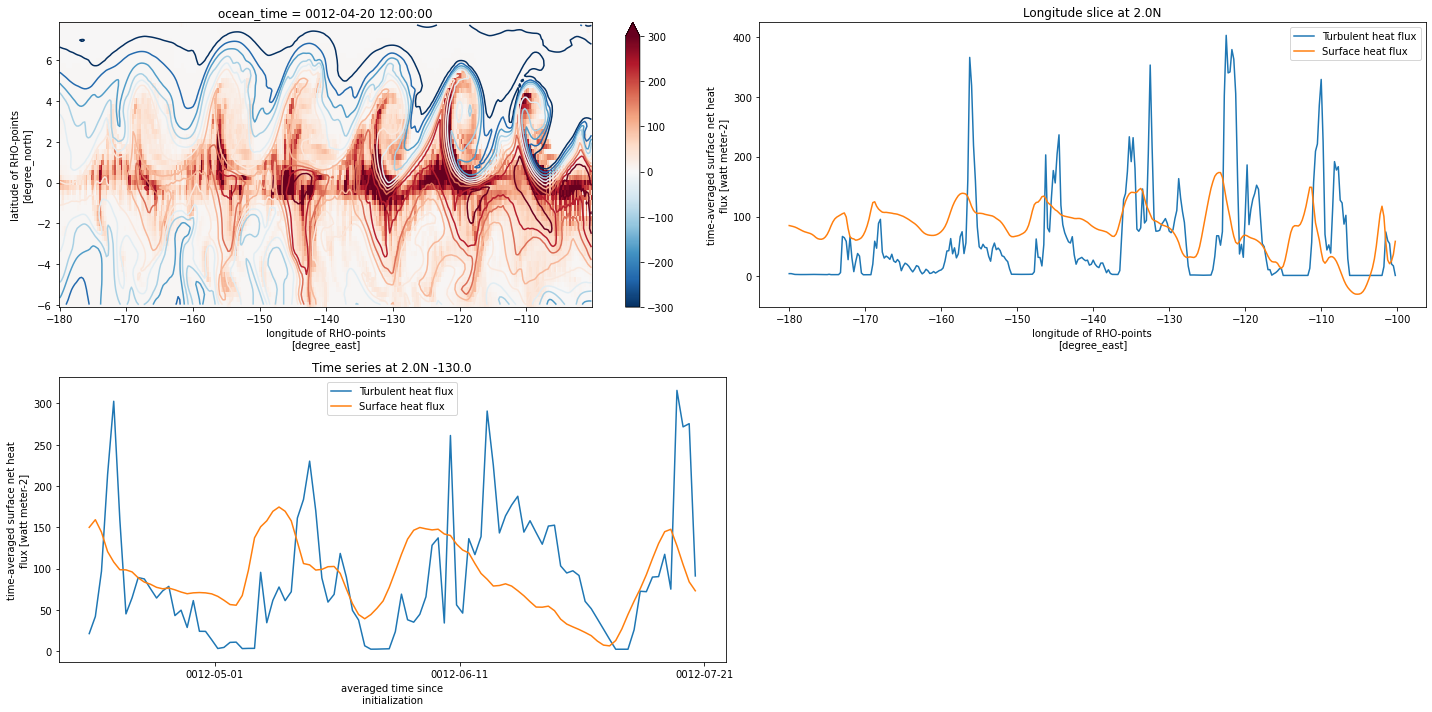

In [6]:
plt.figure(figsize=(20,10))
#xlims = [-180.,-100.]
#ylims = [-10.,10.]
time = 10

lt = 2.0
ln = -130.
lt_ind = int(abs(favg.lat_rho.isel(xi_rho=0)-lt).argmin())
ln_ind = int(abs(favg.lon_rho.isel(eta_rho=0)-ln).argmin())

plt.subplot(2,2,1)
Fz_diff_max.isel(ocean_time=time).plot(vmin=-300.,vmax=300.,cmap='RdBu_r',x='lon_rho',y='lat_rho')
favg.shflux.isel(ocean_time=time).plot.contour(x='lon_rho',y='lat_rho',levels=np.arange(0.,200.,20.))
#plt.xlim(xlims)
#plt.ylim(ylims)

plt.subplot(2,2,2)
Fz_diff_max.isel(ocean_time=time).isel(eta_rho=lt_ind).plot(x='lon_rho',label='Turbulent heat flux')
favg.shflux.isel(ocean_time=time).isel(eta_rho=lt_ind).plot(x='lon_rho',label='Surface heat flux')
#plt.xlim(xlims)
plt.legend()
plt.title('Longitude slice at ' + str(lt) + 'N')

plt.subplot(2,2,3)
Fz_diff_max.isel(eta_rho=lt_ind).isel(xi_rho=ln_ind).plot(label='Turbulent heat flux')
favg.shflux.isel(eta_rho=lt_ind).isel(xi_rho=ln_ind).plot(label='Surface heat flux')
plt.legend()
plt.title('Time series at ' + str(lt) + 'N ' + str(ln))

plt.tight_layout()

In [13]:
np.corrcoef([Fz_diff_max.isel(eta_rho=lt_ind).isel(xi_rho=ln_ind).shift(ocean_time=-5).fillna(0.).values,favg.shflux.isel(eta_rho=lt_ind).isel(xi_rho=ln_ind).values])

array([[1.        , 0.42315138],
       [0.42315138, 1.        ]])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/utils.py:37: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/utils.py:37: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/worker.py:4256: RuntimeWarning: All-NaN slice encountered
  return func(*map(execute_task, args))


(-10.0, 10.0)

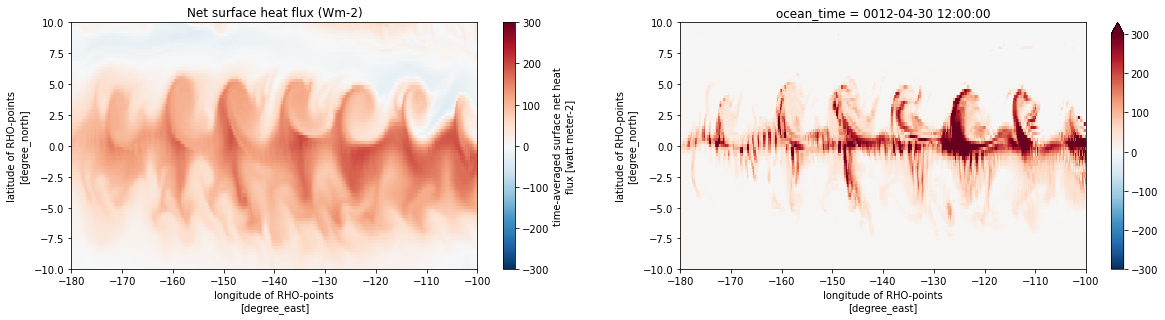

In [17]:
plt.figure(figsize=(20,10))
xlims = [-180.,-100.]
ylims = [-10.,10.]

plt.subplot(2,2,1)
favg.shflux.isel(ocean_time=0).plot(vmin=-300.,vmax=300.,cmap='RdBu_r',x='lon_rho',y='lat_rho')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('Net surface heat flux (Wm-2)')

plt.subplot(2,2,2)
Fz_diff_max.isel(ocean_time=0).plot(vmin=-300.,vmax=300.,cmap='RdBu_r',x='lon_rho',y='lat_rho')
plt.xlim(xlims)
plt.ylim(ylims)

#plt.subplot(2,2,3)
#Fz_shf.isel(s_w=-10).plot(vmin=-300.,vmax=300.,cmap='RdBu_r',x='lon_rho',y='lat_rho')
#plt.xlim(xlims)
#plt.ylim(ylims)

#plt.subplot(2,2,4)
#Fz_diff.isel(s_w=-10).plot(vmin=-300.,vmax=300.,cmap='RdBu_r',x='lon_rho',y='lat_rho')
#favg.shflux.isel(ocean_time=0).plot.contour(x='lon_rho',y='lat_rho',levels=np.arange(0.,200.,20.))
#plt.xlim(xlims)
#plt.ylim(ylims)

Text(0.5, 1.0, 'Net surface heat flux (Wm-2)')

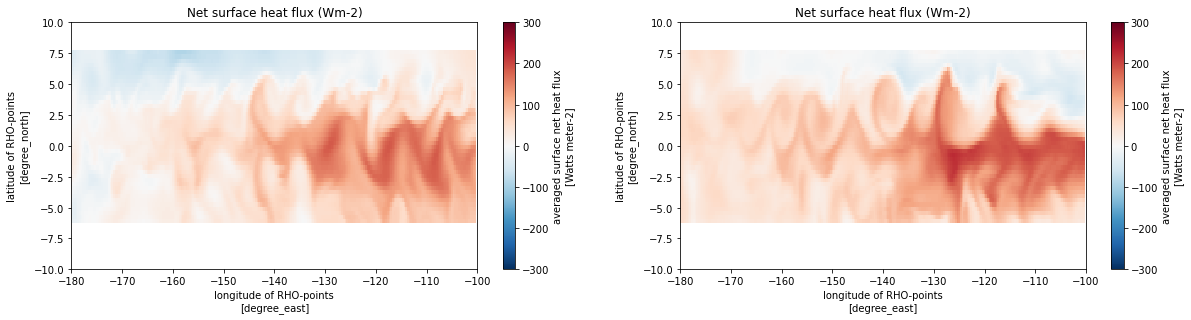

In [24]:
plt.figure(figsize=(20,10))
xlims = [-180.,-100.]
ylims = [-10.,10.]

plt.subplot(2,2,1)
CROCOavg.shflux.isel(time=-1).plot(vmin=-300.,vmax=300.,cmap='RdBu_r',x='lon_rho',y='lat_rho')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('Net surface heat flux (Wm-2)')

plt.subplot(2,2,2)
CROCOavg.shflux.isel(time=-100).plot(vmin=-300.,vmax=300.,cmap='RdBu_r',x='lon_rho',y='lat_rho')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('Net surface heat flux (Wm-2)')

## Meridional overturning circulation:

In [71]:
# Define vertical grid:
ztop, zbot, dz = 10., 400., 10.
zvec = np.arange(-zbot,ztop+dz,dz)
zvec_mid = (zvec[1:]+zvec[0:-1])/2.

# Calculate zonally-integrated Eulerian time-mean MOC:
PsiY = histogram(favg_mean.z_v.fillna(0.),bins=zvec,weights=favg_mean.Hvom.fillna(0.),dim=['xi_v','s_rho'])
PsiY.coords["lat_v"] = favg_mean.lat_v.mean('xi_v')
PsiY = PsiY.cumsum('z_v_bin').rename({'z_v_bin':'z_v_edges'})
PsiY['z_v_edges'] = zvec[1:]
PsiY.load()

# Notes:
# This is done using xhistogram for xarray, see https://xhistogram.readthedocs.io/en/latest/tutorial.html
# Also see Jan's true zonal mean method in the COSIMA recipes https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/True_Zonal_Mean.ipynb

<xarray.DataArray 'histogram_z_v' (ocean_time: 1, eta_v: 252, z_v_edges: 41)>
array([[[ 1.7406367e+05,  4.0444741e+05,  1.3884832e+06, ...,
          1.6923682e+07,  1.7766156e+07,  1.7766156e+07],
        [ 1.7292470e+05,  3.1013881e+05,  1.8469322e+06, ...,
          1.9995288e+07,  2.1098876e+07,  2.1098876e+07],
        [ 2.2039627e+05,  4.2435872e+05,  1.8771024e+06, ...,
          2.1742194e+07,  2.2307044e+07,  2.2307044e+07],
        ...,
        [ 3.2967722e+05,  4.9519744e+05,  6.7366512e+05, ...,
         -2.2716370e+06, -4.8643150e+05, -4.8643150e+05],
        [-1.3815527e+04,  2.5208981e+05,  4.7385050e+05, ...,
          9.9372812e+05,  2.6748300e+06,  2.6748300e+06],
        [ 8.5731031e+04,  1.5367866e+05,  9.3495175e+05, ...,
          8.6036510e+06,  1.0133149e+07,  1.0133149e+07]]], dtype=float32)
Coordinates:
  * ocean_time  (ocean_time) object 0012-08-25 12:00:00
  * z_v_edges   (z_v_edges) float64 -390.0 -380.0 -370.0 ... -10.0 0.0 10.0
    lat_v       (eta_v) float64 -29.89 -29.68 -29.46 -29.24 ... 29.5 29.72 29.94
Dimensions without coordinates: eta_v

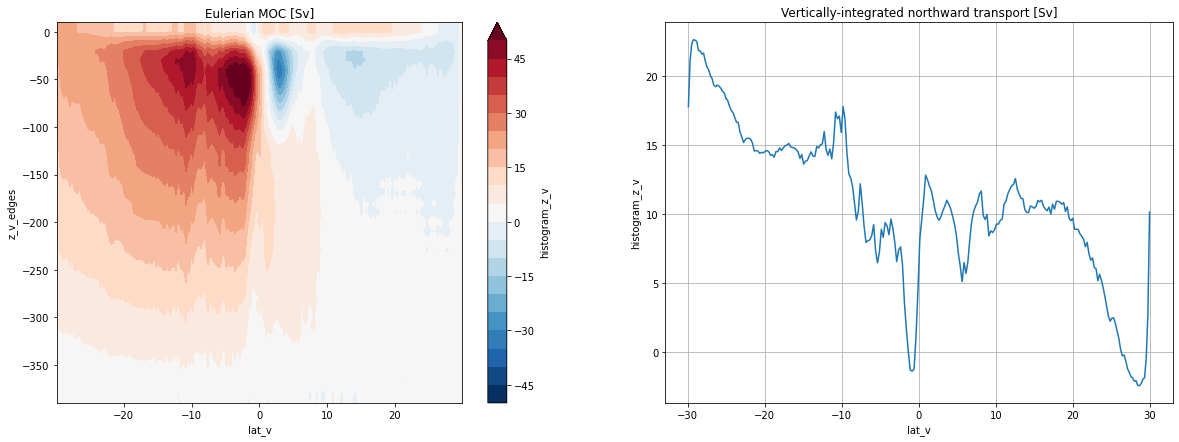

In [72]:
# Plot next to the surface values:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
(PsiY.isel(ocean_time=0)/1.e6).plot.contourf(levels=np.arange(-50.,55.,5.),cmap='RdBu_r',x='lat_v',y='z_v_edges')
plt.title('Eulerian MOC [Sv]')

plt.subplot(1,2,2)
(PsiY.isel(ocean_time=0).isel(z_v_edges=-1)/1.e6).plot(x='lat_v')
plt.title('Vertically-integrated northward transport [Sv]')
plt.grid()


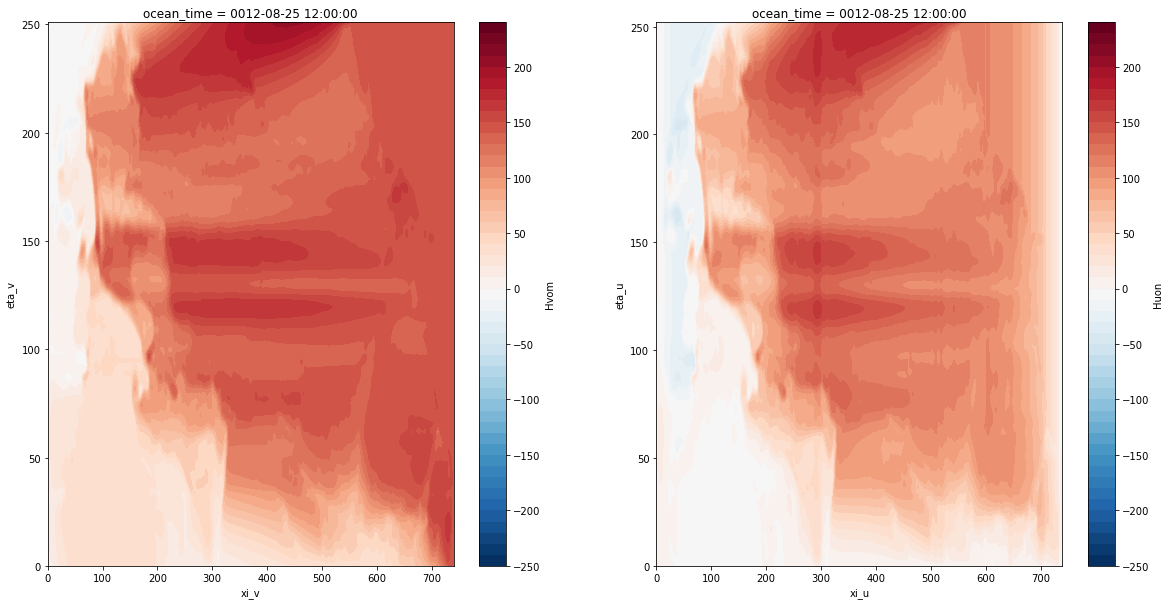

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
(favg_mean.Hvom.sum('s_rho').cumsum('xi_v')/1.e6).isel(ocean_time=0).plot.contourf(levels=np.arange(-250.,250.,10.),cmap='RdBu_r')
plt.subplot(1,2,2)
(-favg_mean.Huon.sum('s_rho').cumsum('eta_u')/1.e6).isel(ocean_time=0).plot.contourf(levels=np.arange(-250.,250.,10.),cmap='RdBu_r')

In [17]:
# Add/calculate vertical coordinate (not needed if pre-calculated using ROMS matlab software):
if favg.Vtransform == 1:
    Zo_rho = favg.hc * (favg.s_rho - favg.Cs_r) + favg.Cs_r * favg.h
    z_rho = Zo_rho + favg.zeta * (1 + Zo_rho / favg.h)
elif favg.Vtransform == 2:
    Zo_rho = (favg.hc * favg.s_rho + favg.Cs_r * favg.h) / (favg.hc + favg.h)
    z_rho = favg.zeta + (favg.zeta + favg.h) * Zo_rho

favg.coords["z_rho"] = z_rho.transpose()  # needing transpose seems to be an xarray bug
fdia.coords["z_rho"] = z_rho.transpose()  # needing transpose seems to be an xarray bug
favg_mean.coords["z_rho"] = z_rho.transpose().mean('ocean_time')  # needing transpose seems to be an xarray bug
favg_mean.temp

<xarray.DataArray 'temp' (ocean_time: 1, s_rho: 50, eta_rho: 253, xi_rho: 741)>
dask.array<xarray-temp, shape=(1, 50, 253, 741), dtype=float32, chunksize=(1, 50, 253, 741), chunktype=numpy.ndarray>
Coordinates:
    Vtransform  int32 1
    hc          float64 75.0
  * s_rho       (s_rho) float64 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    Cs_r        (s_rho) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    h           (eta_rho, xi_rho) float64 dask.array<chunksize=(253, 741), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(253, 741), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(253, 741), meta=np.ndarray>
  * ocean_time  (ocean_time) object 0012-08-25 12:00:00
    z_rho       (eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(253, 741, 50), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:     time-averaged potential temperature
    units:         Celsius
    time:          ocean_time
    grid:          grid
    location:      face
    field:         temperature, scalar, series
    cell_methods:  ocean_time: mean